<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/example%20modelling%20ECG%20timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

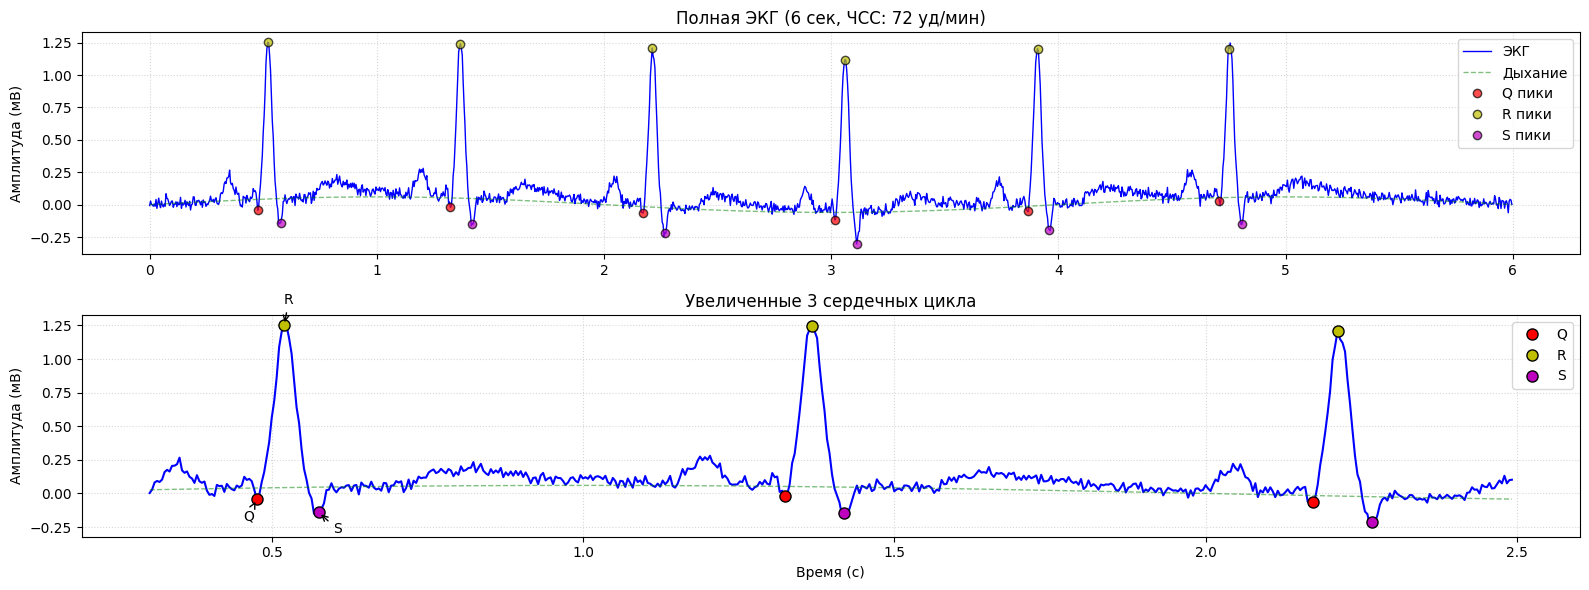

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def multi_beat_ECG(bpm=75, duration=5, fs=250, amp=1.0, show_peaks=True):
    """Генератор ЭКГ с отображением нескольких ударов"""
    t = np.arange(0, duration, 1/fs)
    ecg = np.zeros_like(t)
    respiration = 0.05 * amp * np.sin(2*np.pi*0.25*t)

    # Параметры
    RR = 60/bpm
    beat_times = np.arange(0.4, duration-RR, RR*(0.98 + 0.04*np.random.rand()))

    # Для хранения пиков
    q_peaks = []; r_peaks = []; s_peaks = []

    # Генерация сигнала
    for beat_time in beat_times:
        # P волна
        p_time = np.linspace(-0.04, 0.04, int(0.08*fs))
        p_wave = 0.15*amp * np.exp(-(p_time/0.03)**2)
        ecg += np.interp(t, beat_time-0.05+p_time, p_wave, left=0, right=0)

        # QRS комплекс
        qrs_center = beat_time + 0.12
        q = -0.35*amp * np.exp(-((t-(qrs_center-0.03))/0.02)**4)
        r = amp * np.exp(-((t-qrs_center)/0.035)**2)
        s = -0.3*amp * np.exp(-((t-(qrs_center+0.04))/0.025)**4)

        # T волна
        t_wave = 0.25*amp * (np.exp(-(t-(qrs_center+0.2))/0.15) -
                        np.exp(-(t-(qrs_center+0.2))/0.05))
        t_wave[t<(qrs_center+0.2)] = 0

        ecg += q + r + s + t_wave

        # Поиск пиков
        if show_peaks:
            qrs_mask = (t >= qrs_center-0.06) & (t <= qrs_center+0.08)
            qrs_segment = ecg[qrs_mask]
            qrs_time = t[qrs_mask]

            # R пик
            r_pos = np.argmax(qrs_segment)
            r_peaks.append(qrs_time[r_pos])

            # Q пик
            q_search = qrs_segment[:r_pos]
            if len(q_search) > 3:
                q_pos = np.argmin(q_search)
                q_peaks.append(qrs_time[q_pos])

            # S пик
            s_search = qrs_segment[r_pos:]
            if len(s_search) > 3:
                s_pos = r_pos + np.argmin(s_search)
                s_peaks.append(qrs_time[s_pos])

    # Финализация сигнала
    ecg += respiration + 0.02*amp*np.random.randn(len(t))

    # Визуализация
    plt.figure(figsize=(16, 6))

    # Полный сигнал
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t, ecg, 'b', label='ЭКГ', linewidth=1)
    ax1.plot(t, respiration, 'g--', label='Дыхание', linewidth=1, alpha=0.5)

    if show_peaks:
        ax1.plot(q_peaks, np.interp(q_peaks, t, ecg), 'ro',
                markersize=6, markeredgecolor='k', label='Q пики', alpha=0.7)
        ax1.plot(r_peaks, np.interp(r_peaks, t, ecg), 'yo',
                markersize=6, markeredgecolor='k', label='R пики', alpha=0.7)
        ax1.plot(s_peaks, np.interp(s_peaks, t, ecg), 'mo',
                markersize=6, markeredgecolor='k', label='S пики', alpha=0.7)

    ax1.set_title(f"Полная ЭКГ ({duration} сек, ЧСС: {bpm} уд/мин)")
    ax1.set_ylabel("Амплитуда (мВ)")
    ax1.grid(True, linestyle=':', alpha=0.5)
    ax1.legend(loc='upper right')

    # Увеличенные 3 удара
    ax2 = plt.subplot(2, 1, 2)
    if len(beat_times) >= 3:
        start = beat_times[0] - 0.1
        end = beat_times[2] + 0.4
    else:
        start = 0.3
        end = duration

    mask = (t >= start) & (t <= end)
    ax2.plot(t[mask], ecg[mask], 'b', linewidth=1.5)
    ax2.plot(t[mask], respiration[mask], 'g--', linewidth=1, alpha=0.5)

    if show_peaks:
        q_mask = [p for p in q_peaks if start <= p <= end]
        r_mask = [p for p in r_peaks if start <= p <= end]
        s_mask = [p for p in s_peaks if start <= p <= end]

        ax2.plot(q_mask, np.interp(q_mask, t, ecg), 'ro',
                markersize=8, markeredgecolor='k', label='Q')
        ax2.plot(r_mask, np.interp(r_mask, t, ecg), 'yo',
                markersize=8, markeredgecolor='k', label='R')
        ax2.plot(s_mask, np.interp(s_mask, t, ecg), 'mo',
                markersize=8, markeredgecolor='k', label='S')

        # Подписи для первого комплекса
        if q_mask and r_mask and s_mask:
            ax2.annotate('Q', xy=(q_mask[0], np.interp(q_mask[0], t, ecg)),
                        xytext=(-10,-15), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"))
            ax2.annotate('R', xy=(r_mask[0], np.interp(r_mask[0], t, ecg)),
                        xytext=(0,15), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"))
            ax2.annotate('S', xy=(s_mask[0], np.interp(s_mask[0], t, ecg)),
                        xytext=(10,-15), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"))

    ax2.set_title("Увеличенные 3 сердечных цикла")
    ax2.set_xlabel("Время (с)")
    ax2.set_ylabel("Амплитуда (мВ)")
    ax2.grid(True, linestyle=':', alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return t, ecg

# Запуск
t, ecg = multi_beat_ECG(bpm=72, duration=6, amp=1.2)